In [1]:
import numpy as np
import pandas as pd
import os
import cv2 
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
from torchvision.transforms import v2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
children = os.listdir('Dataset/D1/ds000228/derivatives/processed/Ages7-12')
infants = os.listdir('Dataset/D1/ds000228/derivatives/processed/Ages3-5')
adults = os.listdir('Dataset/D1/ds000228/derivatives/processed/Adults')

In [3]:
os.listdir('Dataset/D1/ds000228/derivatives/processed')

['.DS_Store', 'Ages7-12', 'Adults', 'Ages3-5']

In [4]:
children.remove('.DS_Store')
infants.remove('.DS_Store')
adults.remove('.DS_Store')

In [5]:
len(children)

114

In [6]:
children_images = []
infants_images = []
adults_images = []

path = 'Dataset/D1/ds000228/derivatives/processed/'

for each in children : 
    image = cv2.imread(path + 'Ages7-12/' + each)
    
    children_images.append(image)

for each in infants : 
    image = cv2.imread(path + 'Ages3-5/' + each)
    #if image != None :
    infants_images.append(image)

for each in adults : 
    image = cv2.imread(path + 'Adults/' + each)
    print(image.shape)
    #if image != None :
    adults_images.append(image)

children_df = pd.DataFrame({'image' : children_images, 'label' : [1]*len(children_images)})
infants_df = pd.DataFrame({'image' : infants_images, 'label' : [0]*len(infants_images)})
adults_df = pd.DataFrame({'image' : adults_images, 'label' : [2]*len(adults_images)})

dataset_df = pd.concat([children_df, infants_df, adults_df], axis = 0)

(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)
(79, 95, 3)


In [7]:
image[:,:,0] == image[:,:,1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [19]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class MRIImageDataset(Dataset):
    def __init__(self, dataset_df, transform=None, target_transform=None):
        self.img_labels = dataset_df['label']
        self.img_dir = dataset_df['image']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        raw_image = self.img_dir.iloc[idx]
        #raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
        raw_image = cv2.resize(raw_image, (224, 224))
        # Add channel dimension for single channel (grayscale) image
        image = raw_image/255.0
        image = torch.from_numpy(image).permute(2, 0, 1).float() # Add channel dimension
        
        label = self.img_labels.iloc[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [20]:
dataset = MRIImageDataset(dataset_df)

In [21]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [22]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [240, 30, 40])
dataset_sizes = {'train' : 240, 'test':40, 'val':30}

In [24]:
batch_size = 8
num_workers = 0
dataloaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        ),
        'test': DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
    }

# Test the shape
for images, labels in dataloaders['train']:
    print("Image shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Image shape: torch.Size([8, 3, 224, 224])
Labels shape: torch.Size([8])


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase == 'train' : 
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)

                if phase == 'val' :
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, train_loss, val_loss, train_acc, val_acc

In [29]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.01)

In [30]:
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0742 Acc: 0.3500
val Loss: 1.0753 Acc: 0.3333
Epoch 1/24
----------
train Loss: 0.7133 Acc: 0.7208
val Loss: 0.8663 Acc: 0.6000
Epoch 2/24
----------
train Loss: 0.5133 Acc: 0.8792
val Loss: 0.6609 Acc: 0.7333
Epoch 3/24
----------
train Loss: 0.4444 Acc: 0.9000
val Loss: 0.6224 Acc: 0.7000
Epoch 4/24
----------
train Loss: 0.2984 Acc: 0.9708
val Loss: 0.5869 Acc: 0.7333
Epoch 5/24
----------
train Loss: 0.2733 Acc: 0.9792
val Loss: 0.5755 Acc: 0.7333
Epoch 6/24
----------
train Loss: 0.2667 Acc: 0.9708
val Loss: 0.5656 Acc: 0.7333
Epoch 7/24
----------
train Loss: 0.2484 Acc: 0.9792
val Loss: 0.5844 Acc: 0.7333
Epoch 8/24
----------
train Loss: 0.3197 Acc: 0.9250
val Loss: 0.5701 Acc: 0.7333
Epoch 9/24
----------
train Loss: 0.2345 Acc: 0.9917
val Loss: 0.5689 Acc: 0.7333
Epoch 10/24
----------
train Loss: 0.2802 Acc: 0.9750
val Loss: 0.5787 Acc: 0.7333
Epoch 11/24
----------
train Loss: 0.2451 Acc: 0.9792
val Loss: 0.5792 Acc: 0.7667
Epoch 12/24
--

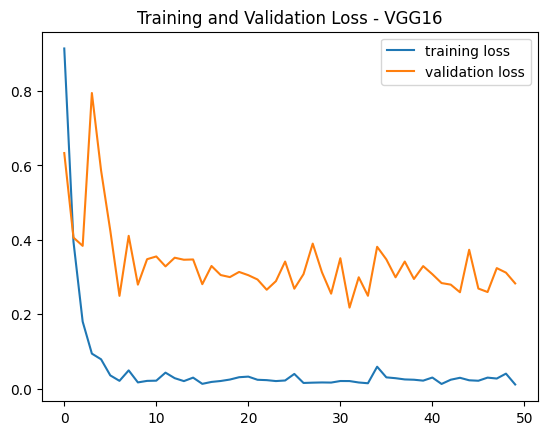

In [17]:
plt.plot(train_loss, label = 'training loss')
plt.legend()
plt.plot(val_loss, label = 'validation loss')
plt.legend()
plt.title('Training and Validation Loss - VGG16')
plt.show()

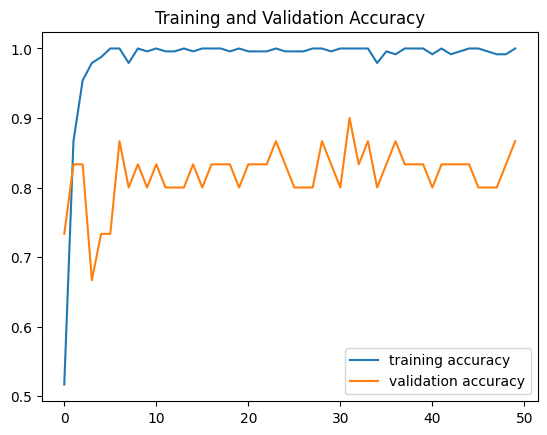

In [18]:
plt.plot(train_acc, label = 'training accuracy')
plt.legend()
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

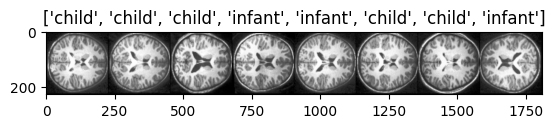

In [304]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
class_names = {
    0 : 'infant',
    1 : 'child',
    2 : 'adult'
}

imshow(out, title=[class_names[x.item()] for x in classes])

In [305]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'  label: {class_names[labels[j].item()]} predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

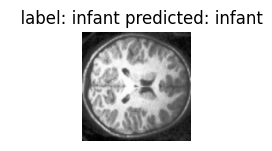

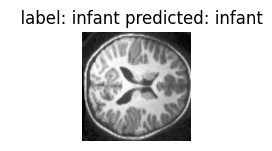

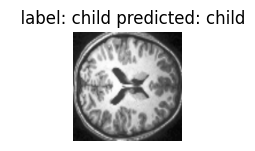

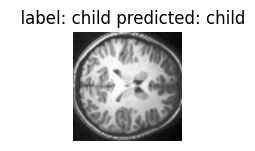

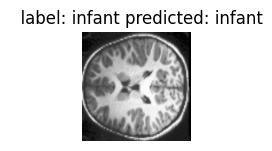

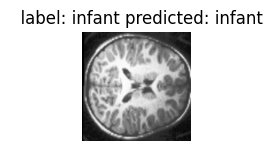

In [306]:
visualize_model(model_ft)

In [307]:
image, label  = next(iter(dataloaders['test']))

In [308]:
model_ft.eval()
outputs = model_ft(image)
_, preds = torch.max(outputs,1)

In [309]:
label

tensor([0, 2, 1, 1, 2, 2, 1, 1])

In [21]:
running_corrects = 0
for image, labels in iter(dataloaders['test']) : 
    model_ft.eval()
    outputs = model_ft(image)
    _, preds = torch.max(outputs,1)
    running_corrects += torch.sum(preds == labels.data)
    print(image.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])


In [26]:
print(running_corrects/40)

tensor(0.8500)


tensor([2, 0, 2, 2, 2, 2, 2, 0])
tensor([2, 0, 0, 0, 0, 1, 2, 0])
tensor([0, 0, 1, 1, 0, 2, 0, 0])
tensor([0, 2, 2, 2, 1, 2, 1, 1])
tensor([2, 0, 2, 1, 0, 1, 0, 1])


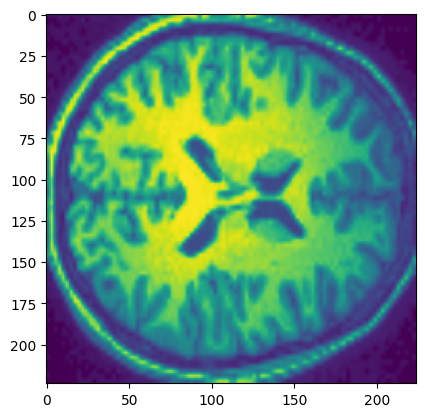

In [28]:
for image, labels in iter(dataloaders['test']) : 
    plt.imshow(image[0][0])
    print(labels)